In [2]:
import numpy as np
import functions as func
import matplotlib.pyplot as plt
import pdb, glob, mpld3, time
from tqdm import tqdm
from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from mpld3 import plugins

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8)
mpld3.enable_notebook()

## BD +60 1753

In [3]:
fnames = np.sort(glob.glob('/data1/phot_cal/spitzer/bd601753/r*/ch1/bcd/*_bcd.fits'))
len(fnames)

19742

In [4]:
hdu = fits.open(fnames[10])
header = hdu[0].header
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / FOUR-BYTE SINGLE PRECISION FLOATING POINT      
NAXIS   =                    2 / STANDARD FITS FORMAT                           
NAXIS1  =                  256 / STANDARD FITS FORMAT                           
NAXIS2  =                  256 / STANDARD FITS FORMAT                           
ORIGIN  = 'Spitzer Science Center' / Organization generating this FITS file     
CREATOR = 'S18.25.0'           / SW version used to create this FITS file       
TELESCOP= 'Spitzer '           / SPITZER Space Telescope                        
INSTRUME= 'IRAC    '           / SPITZER Space Telescope instrument ID          
CHNLNUM =                    1 / 1 digit instrument channel number              
EXPTYPE = 'sci     '           / Exposure Type                                  
REQTYPE = 'IER     '           / Request type (AOR, IER, or  SER)               
AOT_TYPE= 'IRAC    '        

In [13]:
sky = SkyCoord('17 24 52.2772360943 +60 25 50.780790994', unit=(u.hourangle, u.deg))

for fname in tqdm(fnames):
    hdu    = fits.open(fname)
    header = hdu[0].header
    image = hdu[0].data
    hdu.close()
    
    w = WCS(header)
    pix = sky.to_pixel(w)
    
    plot = plt.imshow(image, origin = 'lower', vmin = 0, vmax = 4)
    
    if (pix[0]>0) & (pix[0]<256) & (pix[1]>0) & (pix[1]<256):
        flux, ap = func.photometry(image, [pix[0]], [pix[1]], rad = 5)
        ap.plot(color='y',linewidth=1)
    
        outfile = '../CalStar_ap_test/bd601753/ch1/bd_ch1_' + fname[62:75] + '.pdf'
        plt.title(fname[62:75])
        plt.colorbar(plot)
        plt.savefig(outfile)
        plt.clf()
    else:
        plt.clf()

plt.close()

ValueError: 
FITS WCS distortion paper lookup tables and SIP distortions only work
in 2 dimensions.  However, WCSLIB has detected 3 dimensions in the
core WCS keywords.  To use core WCS in conjunction with FITS WCS
distortion paper lookup tables or SIP distortion, you must select or
reduce these to 2 dimensions using the naxis kwarg.


In [4]:
sky = SkyCoord('17 24 52.2772360943 +60 25 50.780790994', unit=(u.hourangle, u.deg))

#Issues list
crd_conversion = []
centroiding    = []

data = Table(names = ('File#','ACenX', 'ACenY', 'FCenX', 'FCenY', 'Time[MJD]', 'Raw_Flux', 'Bkg_Flux', 'Res_Flux'), 
             dtype= ('S15', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8'))


for fn in tqdm(fnames):
    hdu    = fits.open(fn)
    header = hdu[0].header
    image  = hdu[0].data
    hdu.close()
    
    fnum = fn[62:75]
    Time = header['MJD_OBS']
    
    try:
        w = WCS(header)
        pix = sky.to_pixel(w)
    except:
        crd_conversion.append(fnum)
        continue
    
    if (pix[0]>0) & (pix[0]<256) & (pix[1]>0) & (pix[1]<256):
        
        try:
            cenX, cenY = func.gen_center_g2d(pix[0], pix[1], 7, 5, 4, 4, 0, image)
        except:
            centroiding.append(fnum)
            continue

        # Extracting raw flux
        raw_flux, src_ap = func.photometry(image, [cenX], [cenY], rad = 5)

        # Extrating a mean background flux
        bkg, bkg_ap = func.photometry(image, [cenX], [cenY], shape = 'CircAnn', r_in = 7, r_out = 9)
        bkg_mean = bkg/bkg_ap.area()
        bkg_flux = bkg_mean*src_ap.area()

        # Subtracting background
        res_flux  = raw_flux - bkg_flux

    data.add_row([fnum, pix[0], pix[1], cenX, cenY, Time, raw_flux, bkg_flux, res_flux])

np.save('crd_conversion_issue_bd_ch1.npy', np.array(crd_conversion))
np.save('centroiding_issue_bd_ch1.npy', np.array(centroiding))
ascii.write(data, 'bd_ch1_data.csv')

100%|██████████| 19742/19742 [1:21:33<00:00,  4.03it/s]


In [ ]:
plt.plot(data['Time[MJD]'], data['Raw_Flux'], 'o-')
plt.plot(data['Time[MJD]'], data['Res_Flux'], 'o-')

## hd165459

In [5]:
fnames = np.sort(glob.glob('/data1/phot_cal/spitzer/hd165459/r*/ch1/bcd/*_bcd.fits'))
len(fnames)

10892

In [117]:
sky = SkyCoord('18 02 30.7410086899 +58 37 38.157415821', unit=(u.hourangle, u.deg))

for fname in tqdm(fnames):
    hdu    = fits.open(fname)
    header = hdu[0].header
    image  = hdu[0].data 
    hdu.close()
    
    try:
        w = WCS(header)
        pix = sky.to_pixel(w)
    except:
        continue
    
    plot = plt.imshow(image, origin = 'lower', vmin = 0, vmax = 4)
    
    if (pix[0]>0) & (pix[0]<256) & (pix[1]>0) & (pix[1]<256):
        flux, ap = func.photometry(image, [pix[0]], [pix[1]], rad = 5)
        ap.plot(color='y',linewidth=1)
    
        outfile = '../CalStar_ap_test/hd165459/ch1/hd_ch1_' + fname[62:75] + '.pdf'
        plt.title(fname[62:75])
        plt.colorbar(plot)
        plt.savefig(outfile)
#         pdb.set_trace()
        plt.clf()
    else:
        plt.clf()

plt.close()

In [6]:
sky = SkyCoord('18 02 30.7410086899 +58 37 38.157415821', unit=(u.hourangle, u.deg))

#Issues list
crd_conversion = []
centroiding    = []

data = Table(names = ('File#','ACenX', 'ACenY', 'FCenX', 'FCenY', 'Time[MJD]', 'Raw_Flux', 'Bkg_Flux', 'Res_Flux'), 
             dtype= ('S15', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8'))


for fn in tqdm(fnames):
    hdu    = fits.open(fn)
    header = hdu[0].header
    image  = hdu[0].data
    hdu.close()
    
    fnum = fn[62:75]
    Time = header['MJD_OBS']
    
    try:
        w = WCS(header)
        pix = sky.to_pixel(w)
    except:
        crd_conversion.append(fnum)
        continue
    
    if (pix[0]>0) & (pix[0]<256) & (pix[1]>0) & (pix[1]<256):
        
        try:
            cenX, cenY = func.gen_center_g2d(pix[0], pix[1], 7, 5, 4, 4, 0, image)
        except:
            centroiding.append(fnum)
            continue

        # Extracting raw flux
        raw_flux, src_ap = func.photometry(image, [cenX], [cenY], rad = 5)

        # Extrating a mean background flux
        bkg, bkg_ap = func.photometry(image, [cenX], [cenY], shape = 'CircAnn', r_in = 7, r_out = 9)
        bkg_mean = bkg/bkg_ap.area()
        bkg_flux = bkg_mean*src_ap.area()

        # Subtracting background
        res_flux  = raw_flux - bkg_flux

    data.add_row([fnum, pix[0], pix[1], cenX, cenY, Time, raw_flux, bkg_flux, res_flux])

np.save('crd_conversion_issue_hd_ch1.npy', np.array(crd_conversion))
np.save('centroiding_issue_hd_ch1.npy', np.array(centroiding))
ascii.write(data, 'hd_ch1_data.csv')

100%|██████████| 10892/10892 [53:48<00:00,  3.37it/s]


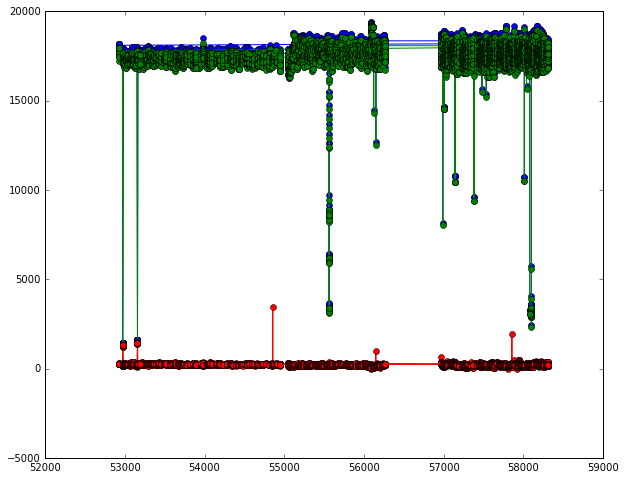

In [21]:
plt.plot(data['Time[MJD]'], data['Raw_Flux'], 'o-')
plt.plot(data['Time[MJD]'], data['Res_Flux'], 'o-')
plt.plot(data['Time[MJD]'], data['Bkg_Flux'], 'o-')

In [10]:
hd_data = ascii.read('hd_ch1_data.csv')
hd_data

File#,ACenX,ACenY,FCenX,FCenY,Time[MJD],Raw_Flux,Bkg_Flux,Res_Flux
str13,float64,float64,float64,float64,float64,float64,float64,float64
11638016_0000,130.204115142,126.80802829,130.205385657,126.525119496,53204.9589689,17280.79676,217.582731405,17063.2140286
11638016_0001,467.738847917,118.198197201,130.205385657,126.525119496,53204.9592097,17280.79676,217.582731405,17063.2140286
11638016_0002,67.7769860643,190.064908182,68.0432073057,189.838214351,53204.9594597,17718.4987023,206.468540936,17512.0301614
11638016_0003,401.592275999,182.442111262,68.0432073057,189.838214351,53204.9596819,17718.4987023,206.468540936,17512.0301614
11638016_0004,193.189569783,189.613813838,193.13645238,189.134013889,53204.9598902,17704.1132683,257.384416515,17446.7288518
11638016_0005,535.692164497,183.535475108,193.13645238,189.134013889,53204.9601125,17704.1132683,257.384416515,17446.7288518
11638016_0006,192.87679071,63.5899235305,193.026840568,63.1090896377,53204.9603579,17862.8007192,301.4909772,17561.309742
11638016_0007,536.361342463,53.2168954741,193.026840568,63.1090896377,53204.96058,17862.8007192,301.4909772,17561.309742
11638016_0008,66.785199777,63.9439145388,67.0511936806,63.4841993491,53204.9608393,17696.8168828,297.255299381,17399.5615834


In [11]:
bd_data = ascii.read('bd_ch1_data.csv')
bd_data

File#,ACenX,ACenY,FCenX,FCenY,Time[MJD],Raw_Flux,Bkg_Flux,Res_Flux
str13,float64,float64,float64,float64,float64,float64,float64,float64
11641856_0000,130.127231671,126.954124127,130.204996285,126.743548224,53204.9626309,1069.06381008,20.382972703,1048.68083738
11641856_0000,130.126604411,126.95375743,130.210546687,126.739876313,53204.9626541,1036.52498967,-8.43654856798,1044.96153824
11641856_0001,467.821380679,118.70908066,130.210546687,126.739876313,53204.962992,1036.52498967,-8.43654856798,1044.96153824
11641856_0001,467.901623142,118.739903258,130.210546687,126.739876313,53204.9630152,1036.52498967,-8.43654856798,1044.96153824
11641856_0002,67.5821841821,189.584247263,67.8758878213,189.20563554,53204.9633578,1052.0485346,12.4035950505,1039.64493955
11641856_0002,67.400804988,189.587760384,67.7570365874,189.246752074,53204.9633809,1018.33387787,-11.511892358,1029.84577023
11641856_0003,401.494674015,182.168459511,67.7570365874,189.246752074,53204.9636957,1018.33387787,-11.511892358,1029.84577023
11641856_0003,401.611948954,182.128148143,67.7570365874,189.246752074,53204.9637188,1018.33387787,-11.511892358,1029.84577023
11641856_0004,193.294811182,189.4110393,193.206486787,189.196411537,53204.9640197,1075.75310644,12.7802537429,1062.9728527


In [12]:
hd_crd = np.load('crd_conversion_issue_hd_ch1.npy')
bd_crd = np.load('crd_conversion_issue_bd_ch1.npy')
hd_cen = np.load('centroiding_issue_hd_ch1.npy')
bd_cen = np.load('centroiding_issue_bd_ch1.npy')

In [17]:
hd_problem_files = len(hd_cen) + len(hd_crd)
bd_problem_files = len(bd_cen) + len(bd_crd)
hd_problem_files, bd_problem_files

(2124, 2644)